# Ideal Parameter Analysis ($\delta=1$, $\tau=1.25$, $\alpha=2$) ($\delta$ lower bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

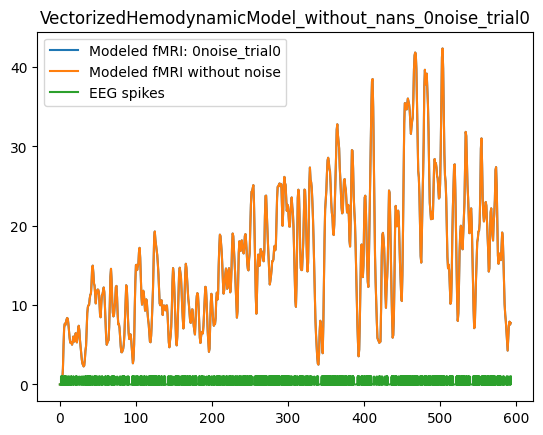

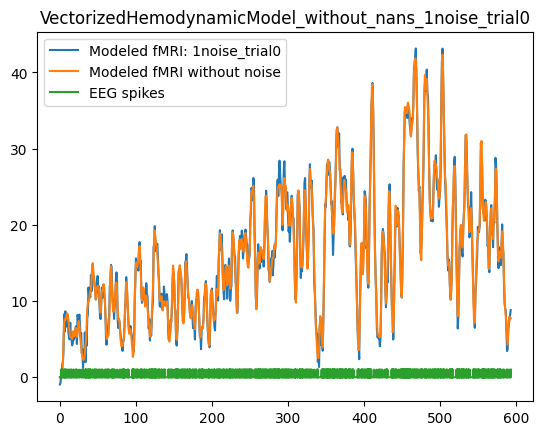

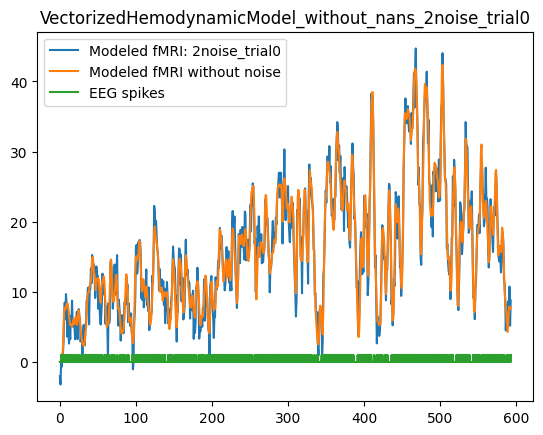

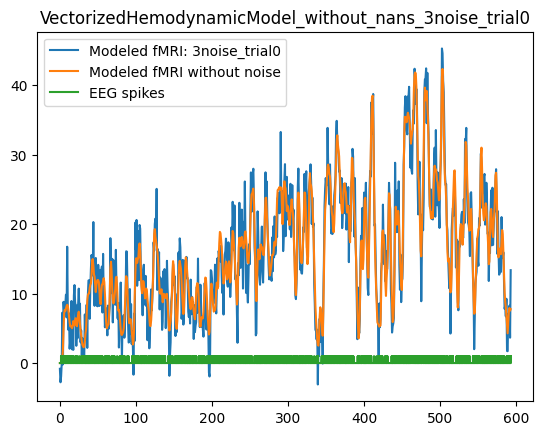

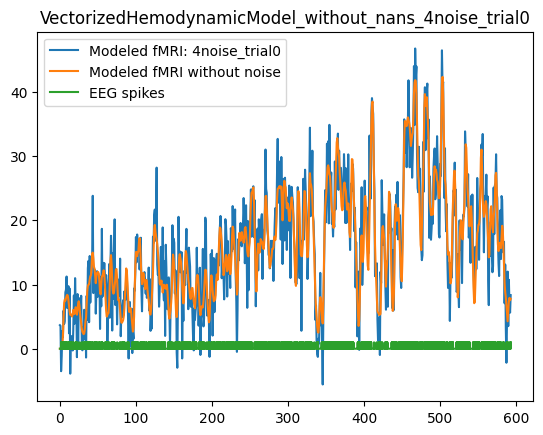

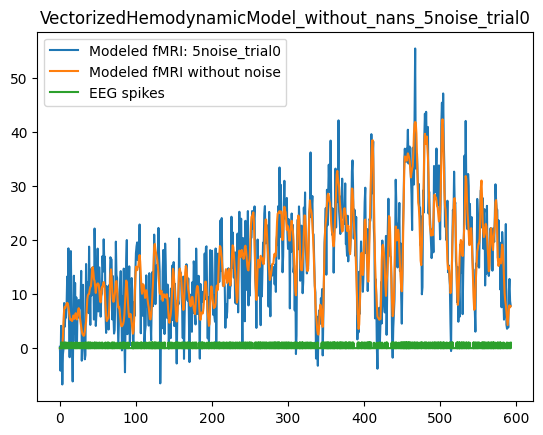

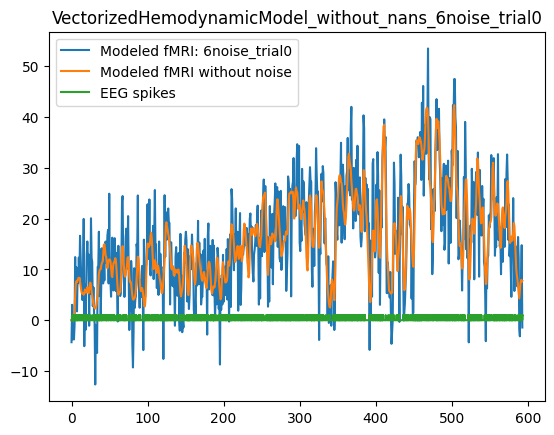

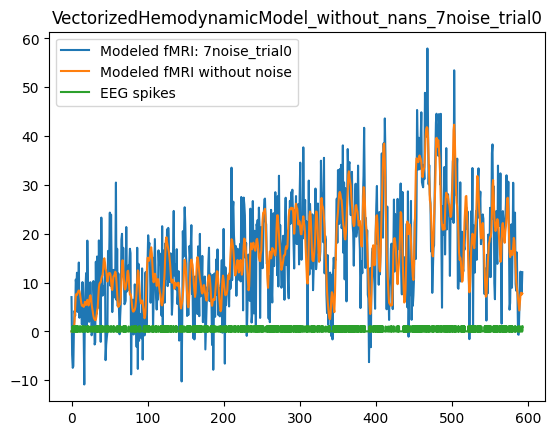

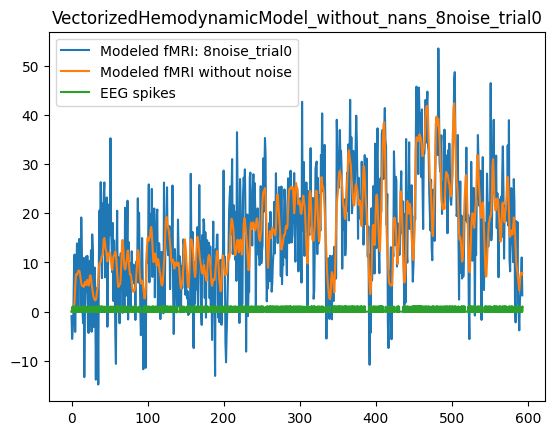

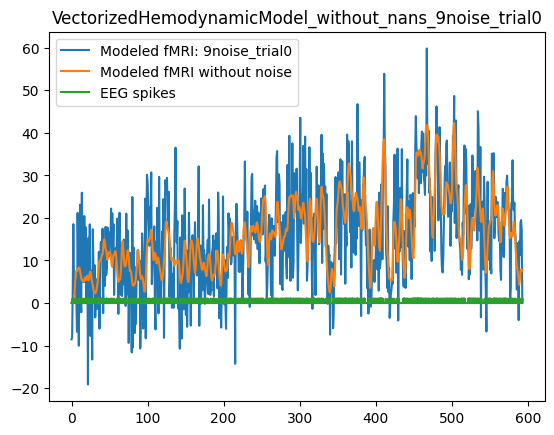

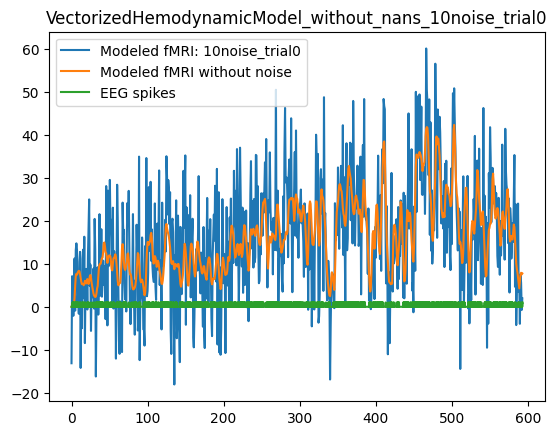

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1, tau=1.25, alpha=2


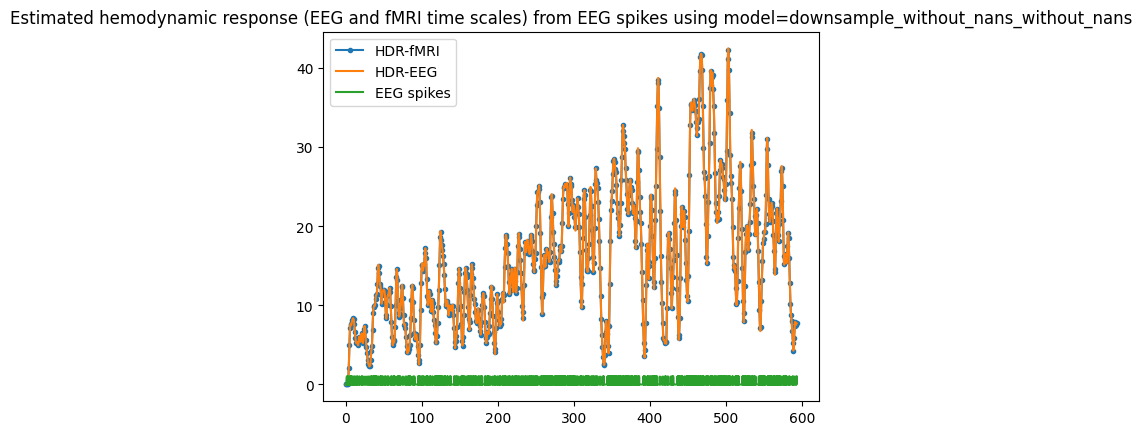

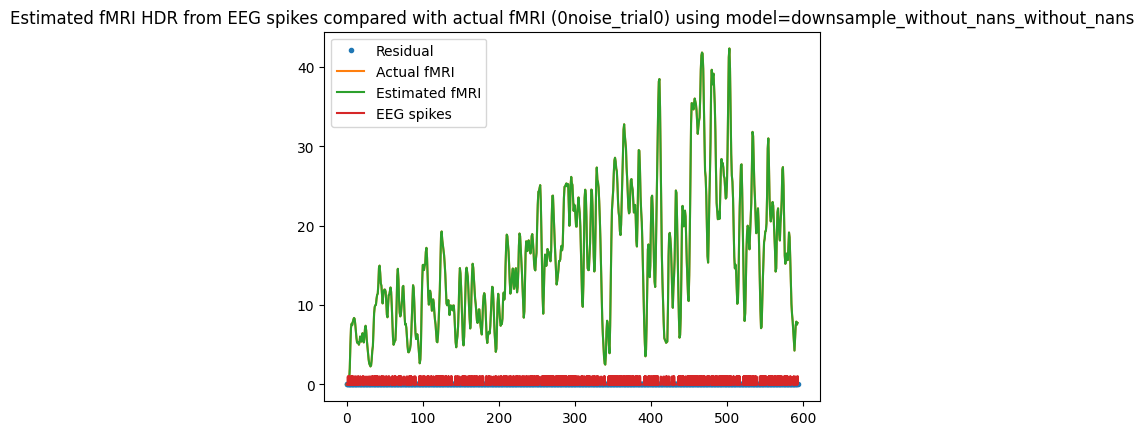

Residual Variance is 0.000000


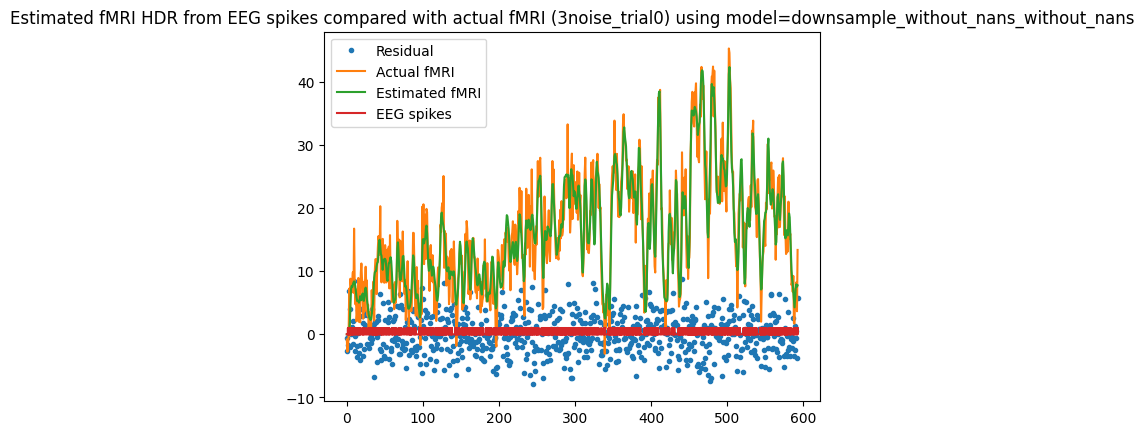

Residual Variance is 9.408301


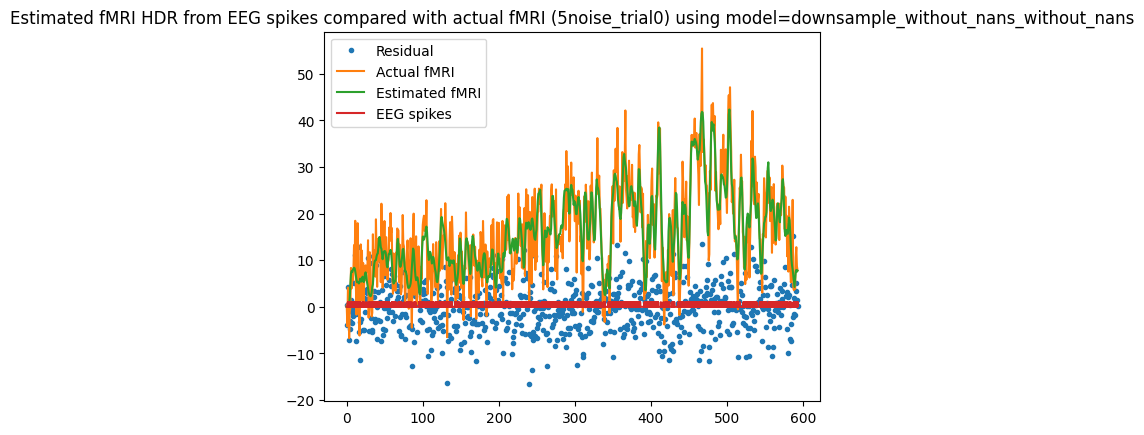

Residual Variance is 25.538987


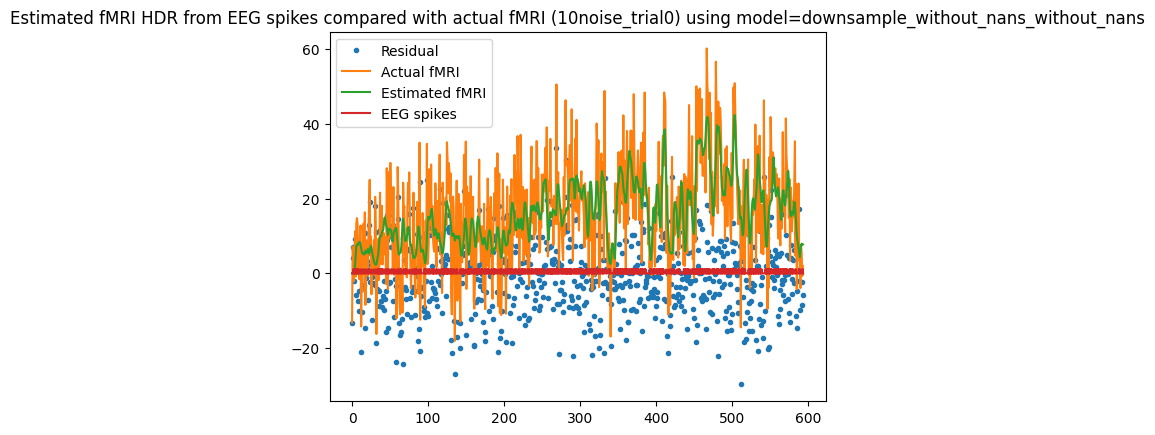

Residual Variance is 104.793838


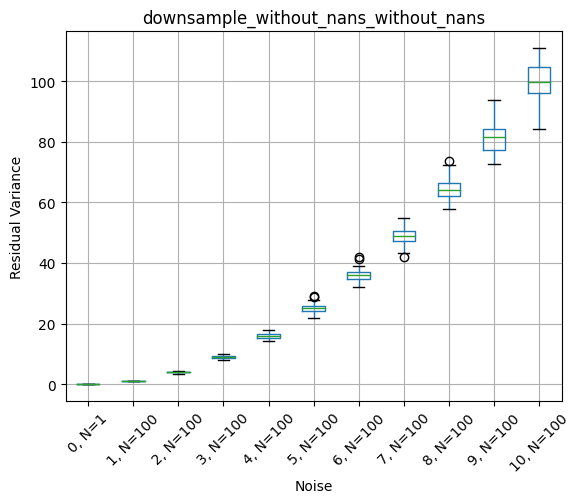

Scoring downsample_without_nans_with_nans delta=1, tau=1.25, alpha=2


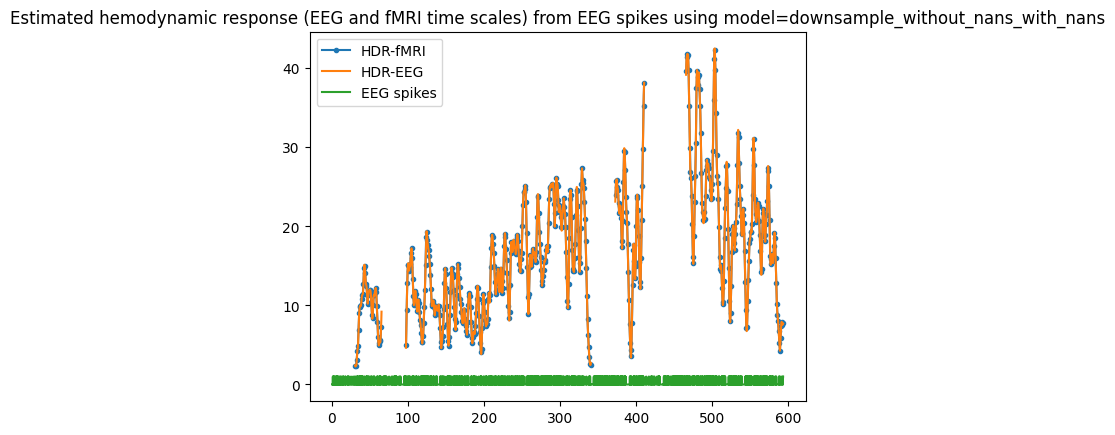

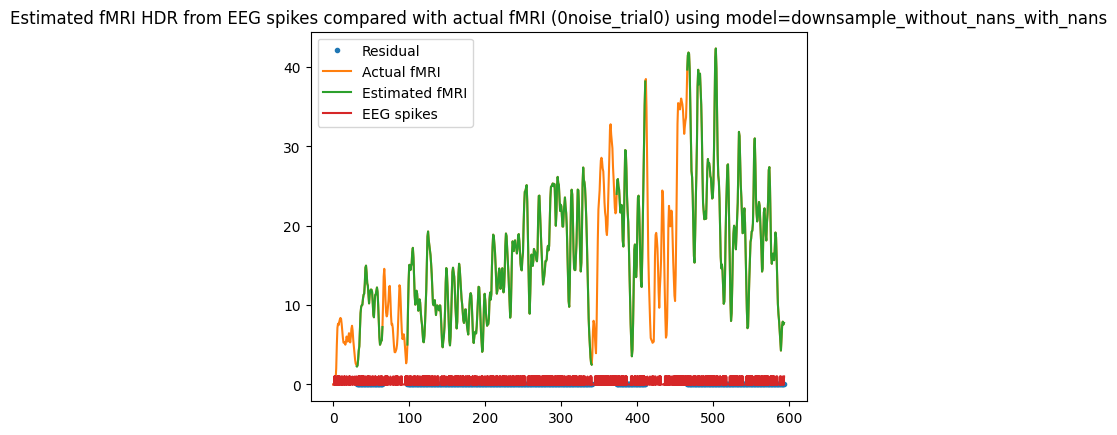

Residual Variance is 0.000000


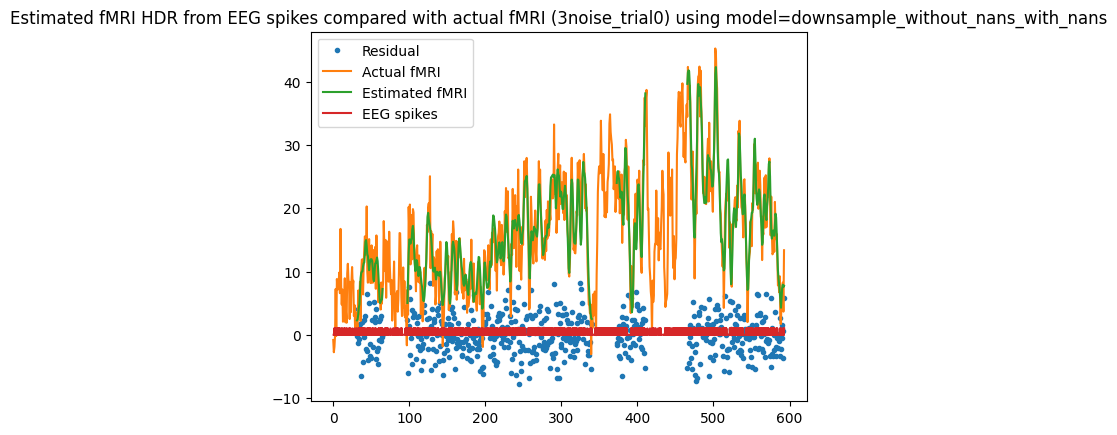

Residual Variance is 9.575219


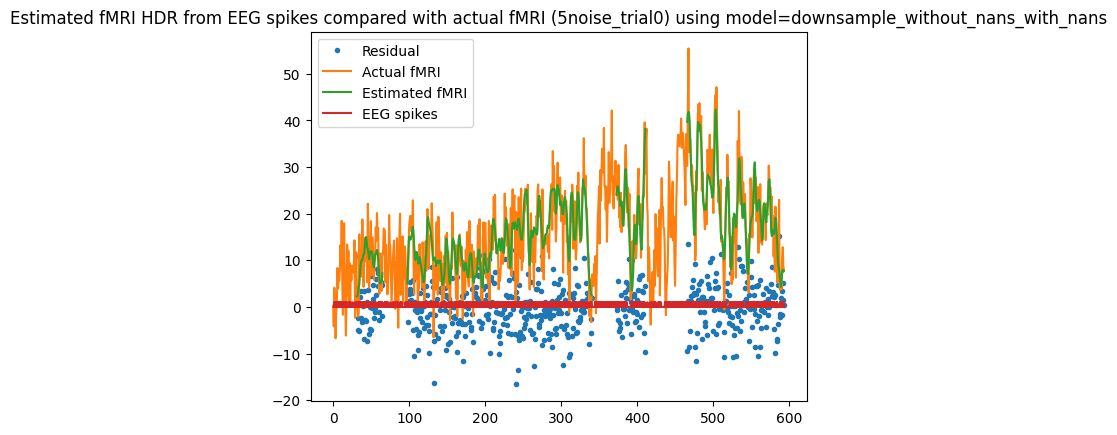

Residual Variance is 24.893302


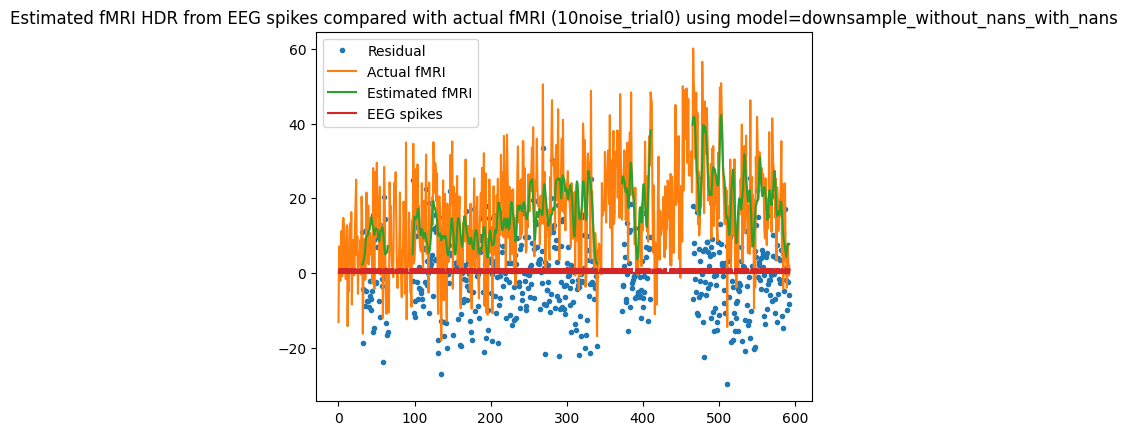

Residual Variance is 107.275303


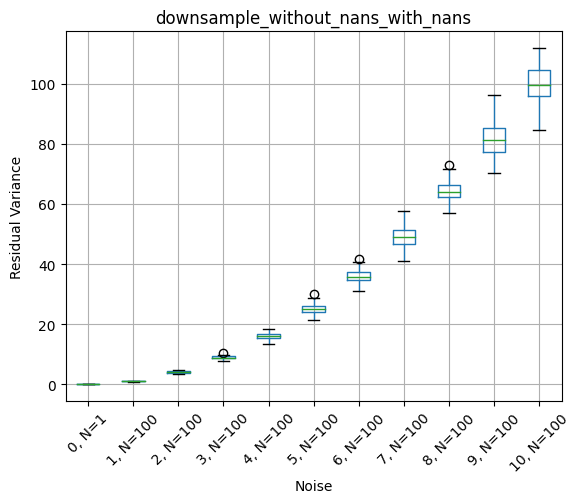

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  17.096689003135662   
1         downsample_without_nans_with_nans  15.867627726779132   
2      downsample_without_nans_without_nans   16.22848529593463   
3         downsample_without_nans_with_nans  15.063709086646847   
4      downsample_without_nans_without_nans  15.382866603575204   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   27.89444213962772   
18938  downsample_without_nans_without_nans   30.80967462062232   
18939     downsample_without_nans_with_nans   28.38145592905553   
18940  downsample_without_nans_without_nans  31.379180517613307   
18941     downsample_without_nans_with_nans  28.854116207077357   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0        18.6981865542588   21.41145557759638  25.652594923575826   
1      17.429016099627407  20.092713128950543  25.304543259195253   
2       17.81576253265301  20.562291905902836   24.77433871779877   
3      16.605028905067854   19.32336138881192  24.481282512978005   
4      16.955828602527802    19.7351305343693  23.920482440475205   
...                   ...                 ...                 ...   
18937  28.577670413314614  30.946638107746086  38.558559753240694   
18938   31.30957244083818   34.09266359442378    42.3378037248549   
18939  29.070519580783287  31.425356173719003   39.05776049230649   
18940  31.886656532537696  34.659943199004225   42.91964023971997   
18941   29.54924597175593   31.89008278248701   39.54269279164186   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      30.960273323324937   44.37236663460655  ...  18.126616178760024   
1       29.69015671235572  42.459669428372074  ...  16.796617205112653   
2      30.127119094305094   43.45548261208467  ...  17.263866484607792   
3       28.92000898492735    41.6251405044335  ...  16.003398855369177   
4       29.31924286215786    42.5587951724008  ...  16.423527283694412   
...                   ...                 ...  ...                 ...   
18937   45.14251550040336  52.360327355762614  ...  28.231641132865526   
18938  46.680916085334765   56.50938673140948  ...   31.62798368870312   
18939  45.606920765113166  52.887697420319725  ...  28.710879040678616   
18940   47.22412485525328   57.11602461981491  ...   32.20205323836811   
18941   46.05687924122654  53.401178332244456  ...  29.176196198397758   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      21.606405161830587   29.07536817533625   32.75172212498838   
1      19.886813067434684  27.273206957827618   32.21348413862222   
2       20.71162397381785  28.156884014517974  31.908891135321113   
3      19.057457507029703   26.44962428737647   31.42145782352891   
4       19.83899546651639   27.25883525310169  31.089419319843305   
...                   ...                 ...                 ...   
18937  31.849030292813328   35.04885188293919  44.292749120031644   
18938   35.38323596922975  38.717233391568215   46.88618804592515   
18939   32.32724434858074  35.562933543698705  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 6.847057476805967e-28; at
     delta   tau  alpha
230    1.0  1.25    2.0


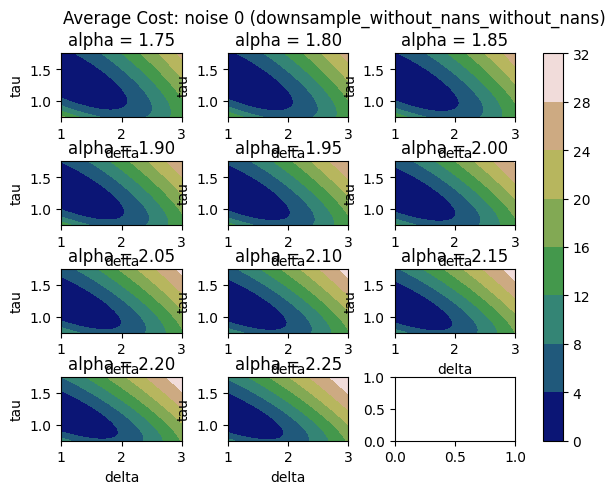

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              17.096689             
2                                              16.228485             
4                                              15.382867             
6                                              14.560328             
8                                              13.761328             
...                                                  ...             
18932                                          29.016868             
18934                                          29.628378             
18936                                          30.226035             
18938                                          30.809675             
18940                                          31.379181             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    1.0  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  8.982129e-03   1.00  1.20   2.10
1      0         0  6.847057e-28   1.00  1.25   2.00
2      0         0  5.308007e-03   1.05  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  8.982129e-03    1.0  1.20    2.1
1      0         0  6.847057e-28    1.0  1.25    2.0

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 5.885141293638846e-28; at
     delta   tau  alpha
231    1.0  1.25    2.0


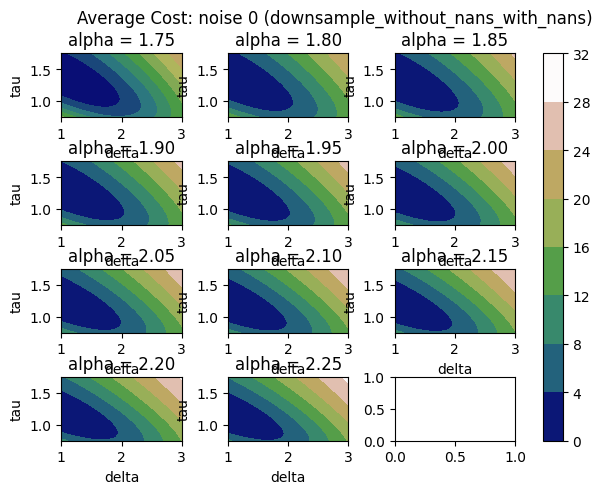

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              15.867628          
3                                              15.063709          
5                                              14.280090          
7                                              13.517264          
9                                              12.775699          
...                                                  ...          
18933                                          26.877450          
18935                                          27.393087          
18937                                          27.894442          
18939                                          28.381456          
18941                                          28.854116          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    1.0  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  8.597677e-03   1.00  1.20   2.10
1      0         0  5.885141e-28   1.00  1.25   2.00
2      0         0  5.315701e-03   1.05  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  8.597677e-03    1.0  1.20    2.1
1      0         0  5.885141e-28    1.0  1.25    2.0

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0044182991251434; at
     delta   tau  alpha
230    1.0  1.25    2.0


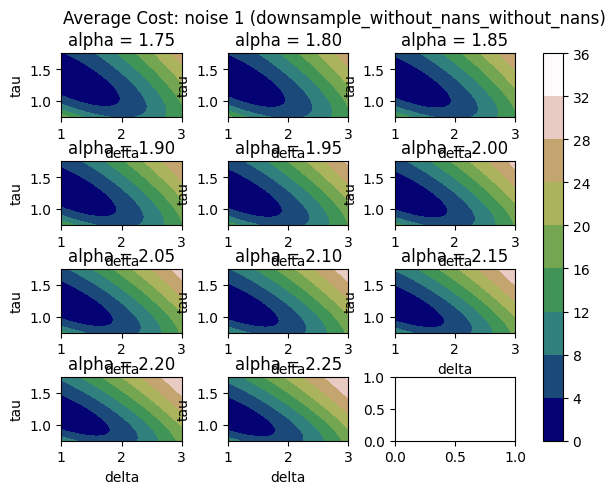

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.02643990774974; at
     delta   tau  alpha
230    1.0  1.25    2.0


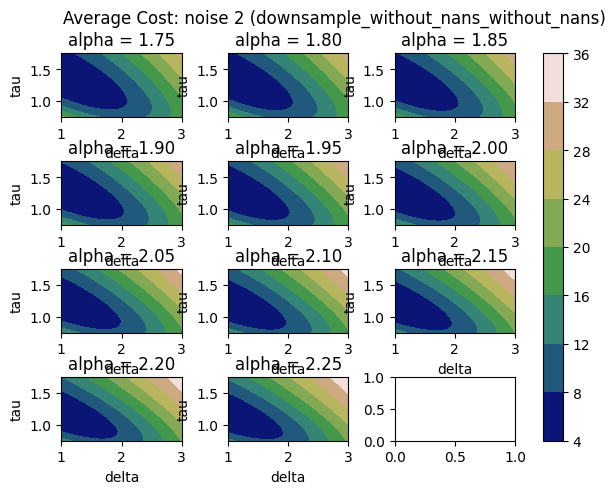

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.882605888054181; at
     delta   tau  alpha
230    1.0  1.25    2.0


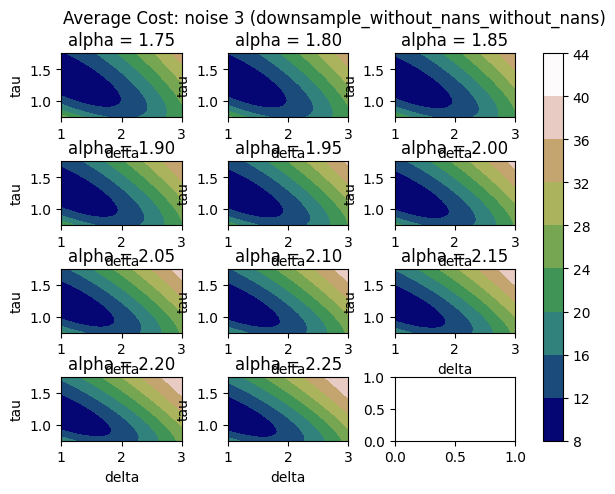

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.953816877699547; at
     delta   tau  alpha
230    1.0  1.25    2.0


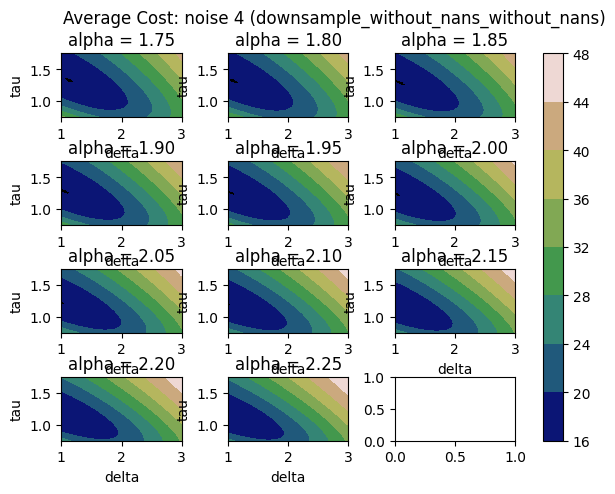

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.988879761647596; at
     delta   tau  alpha
230    1.0  1.25    2.0


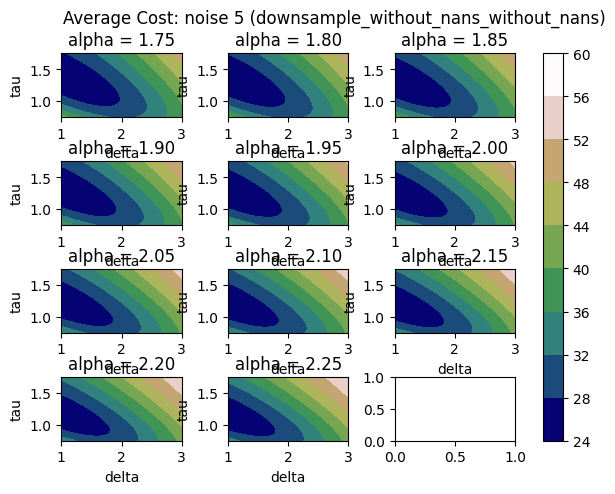

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.08023183391481; at
     delta   tau  alpha
690   1.05  1.25   1.95


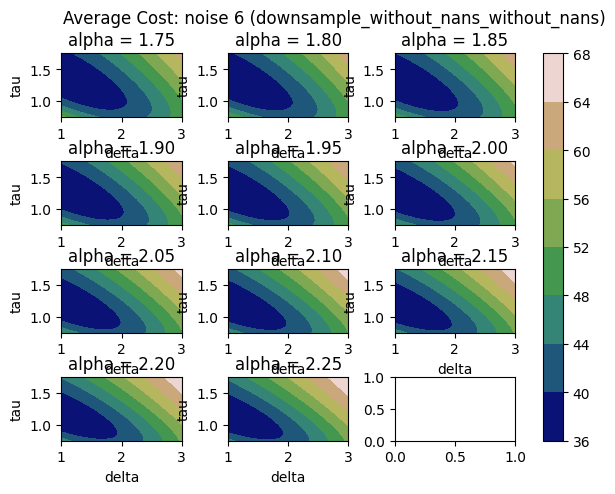

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.865285958930144; at
     delta   tau  alpha
230    1.0  1.25    2.0


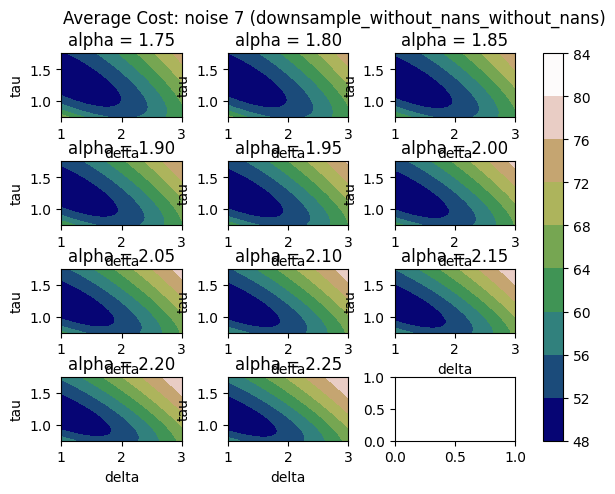

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.26088157736783; at
     delta   tau  alpha
230    1.0  1.25    2.0


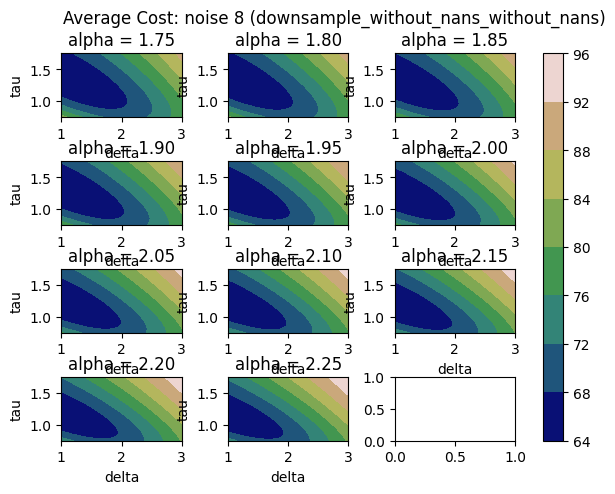

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.13919250812604; at
     delta   tau  alpha
230    1.0  1.25    2.0


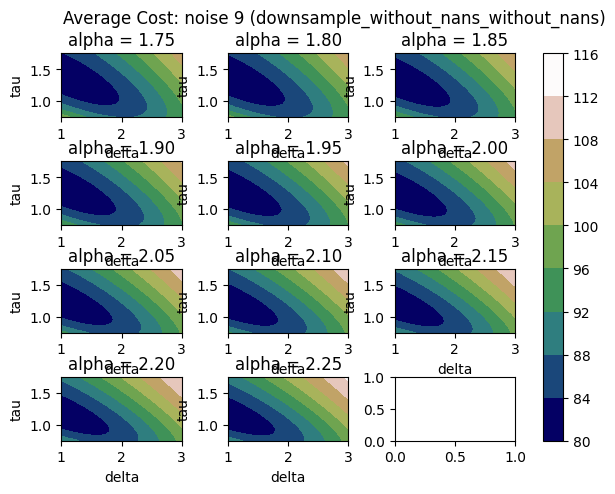

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.98131400120332; at
     delta   tau  alpha
230    1.0  1.25    2.0


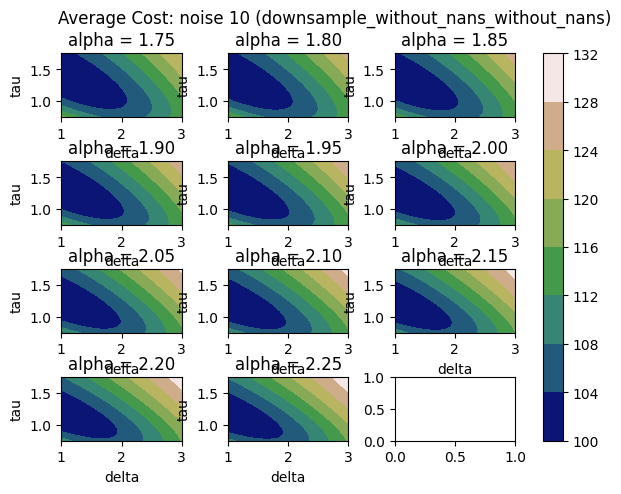

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

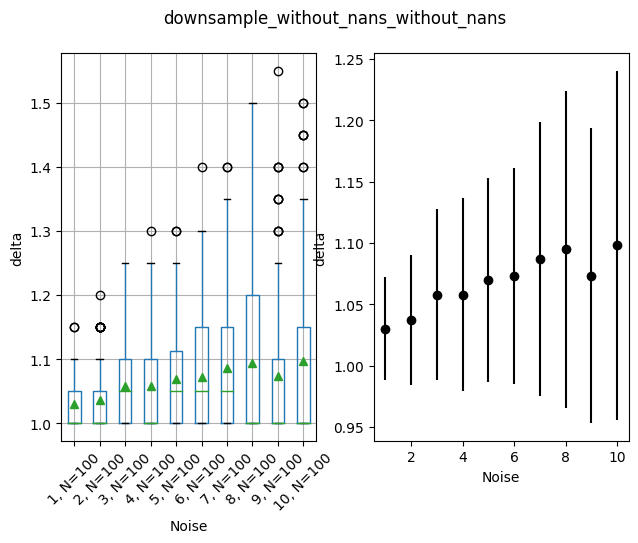

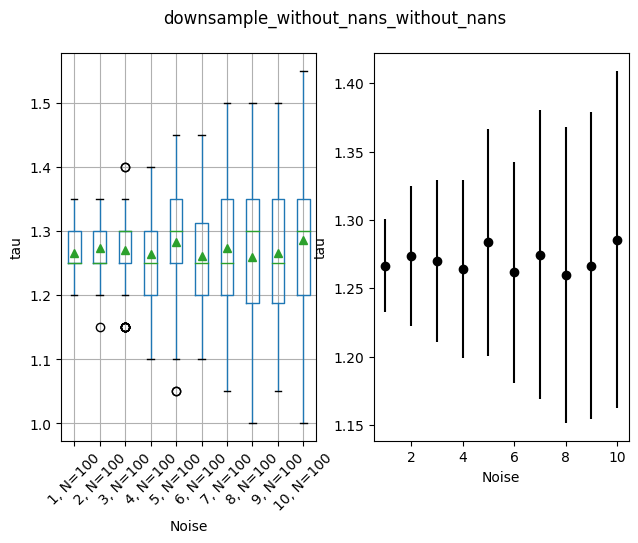

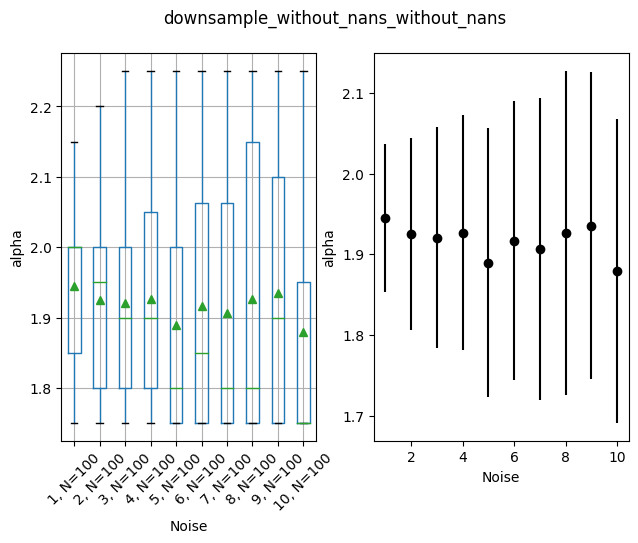

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0084893683933114; at
     delta   tau  alpha
231    1.0  1.25    2.0


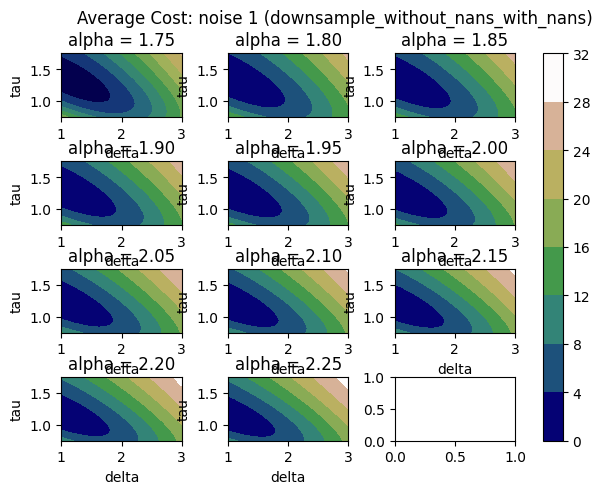

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.030330178861404; at
     delta   tau  alpha
231    1.0  1.25    2.0


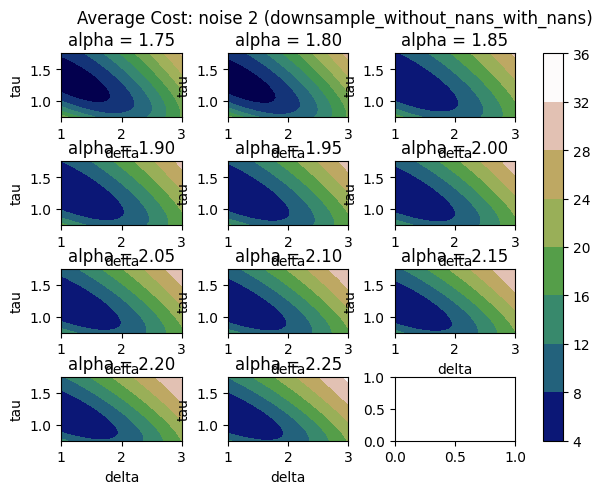

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.871116128561988; at
     delta   tau  alpha
231    1.0  1.25    2.0


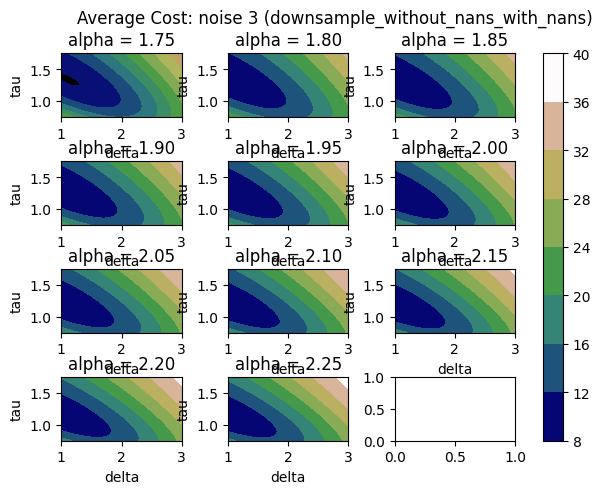

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.936305379367246; at
     delta   tau  alpha
231    1.0  1.25    2.0


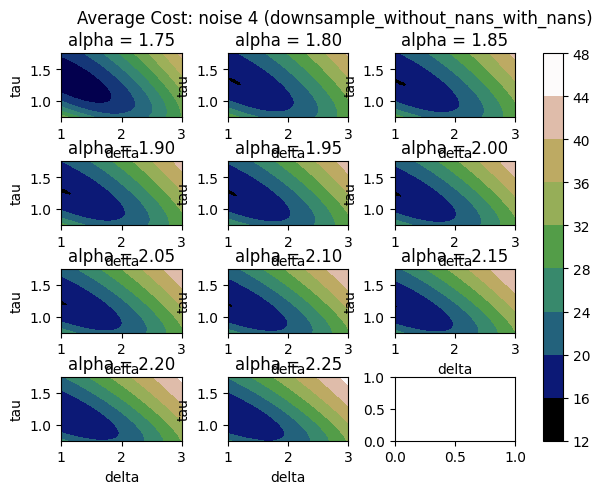

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.07962505809267; at
     delta   tau  alpha
231    1.0  1.25    2.0


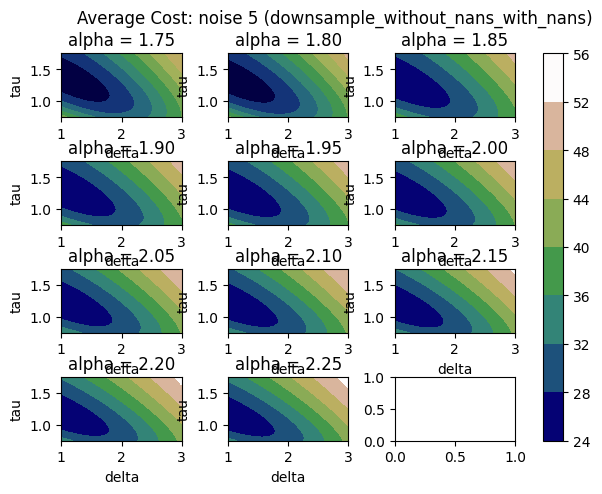

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.89867817665366; at
     delta   tau  alpha
691   1.05  1.25   1.95


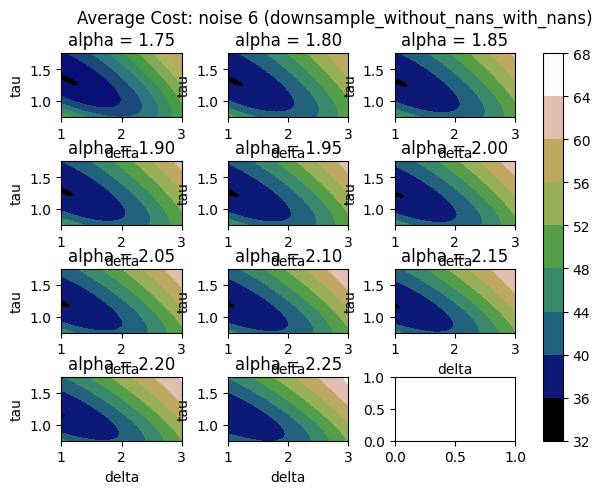

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.91059333463158; at
      delta  tau  alpha
1171    1.1  1.3   1.85


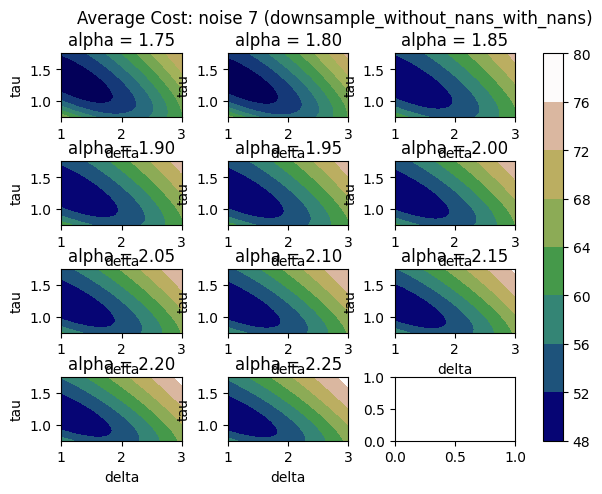

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.98536561766659; at
     delta  tau  alpha
213    1.0  1.2    2.1


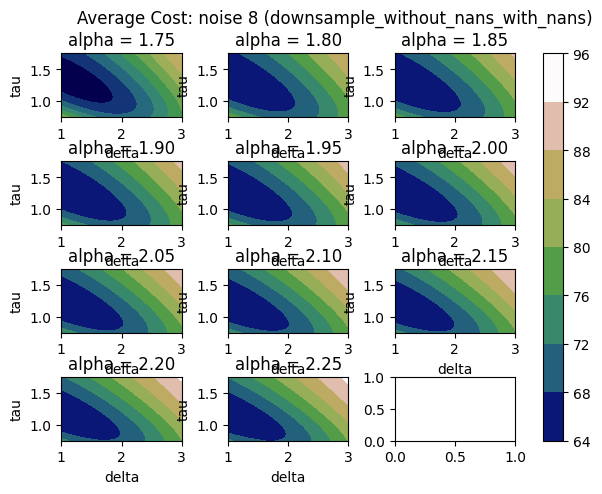

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.32751012585656; at
     delta   tau  alpha
231    1.0  1.25    2.0


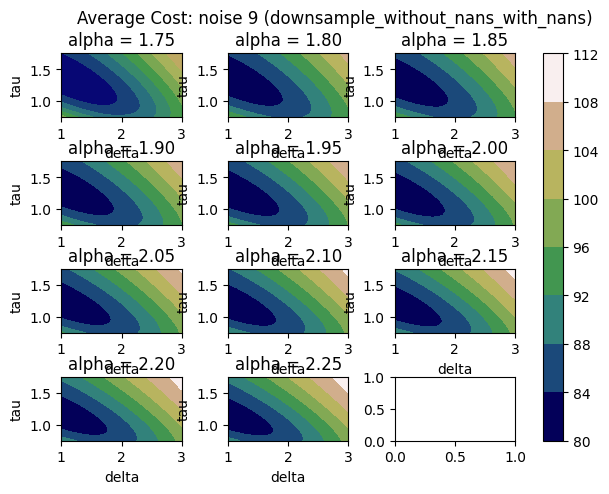

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.0708511534337; at
     delta   tau  alpha
231    1.0  1.25    2.0


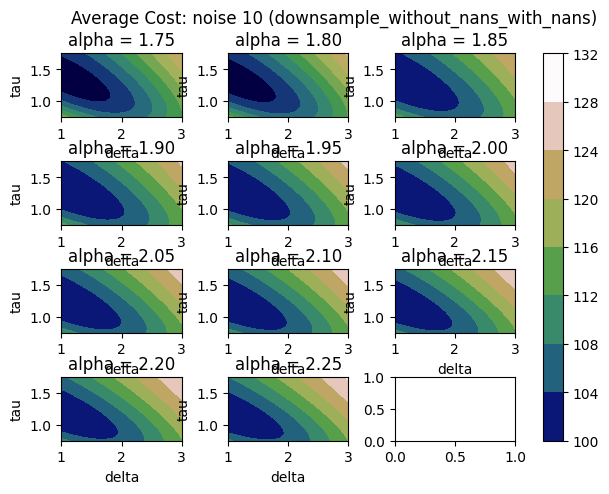

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


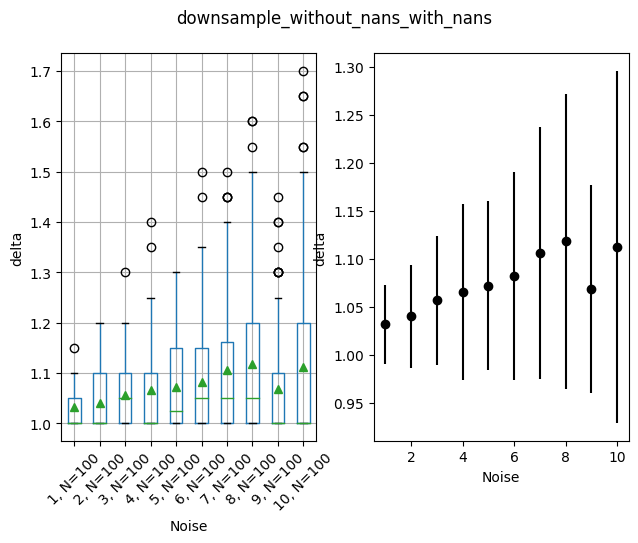

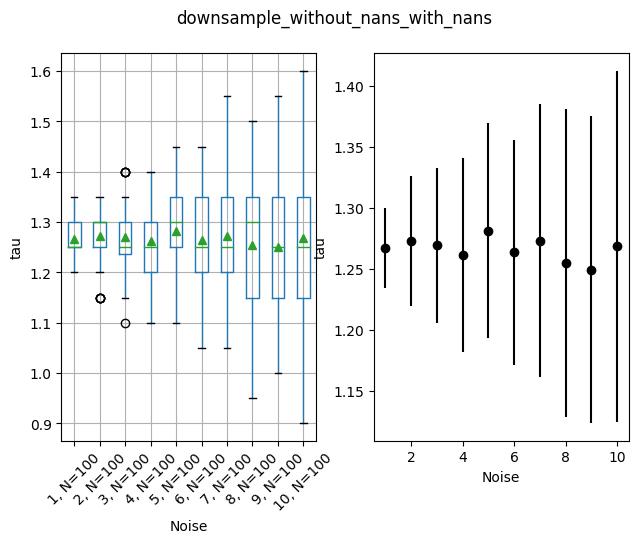

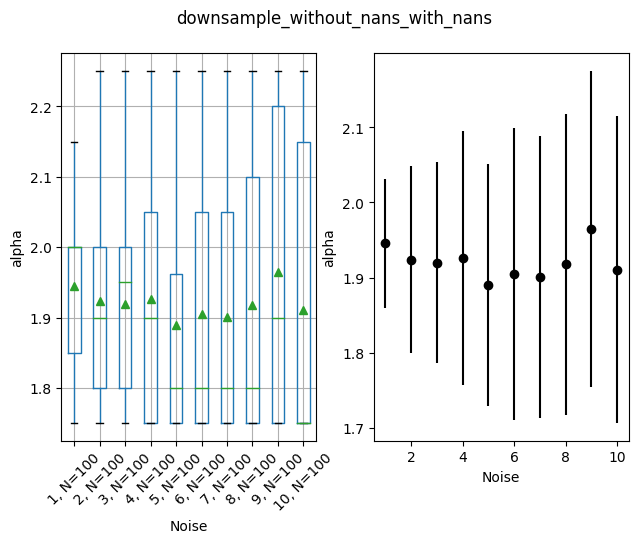

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         1    1.038244                 1.0  1.1500000000000004   
1         1         7    1.004069                 1.0  1.1500000000000004   
2         1        14    1.083485                 1.0  1.1500000000000004   
3         1        23    0.918186                 1.0  1.1500000000000004   
4         1        24    1.152836                 1.0  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2603     10         8  100.424164  1.4500000000000004  1.1500000000000004   
2604     10        30  101.006435  1.4500000000000004  1.2000000000000004   
2605     10        56   99.916053  1.4500000000000004  1.2500000000000004   
2606     10        85   95.255780  1.5000000000000004  1.2000000000000004   
2607     10        20   93.813829  1.5000000000000004  1.2500000000000004   

     alpha  
0      2.2  
1      2.2  
2      2.2  
3      2.2  
4      2.2  
...    ...  
2603  1.75  
2604  1.75  
2605  1.75  
2606  1.75  
2607  1.75  

[2608 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.47  0.521362  3.0  3.0  3.0  4.0  5.0
2                      100.0  3.09  0.817671  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.17  0.910711  1.0  3.0  3.0  4.0  5.0
4                      100.0  2.96  1.024153  1.0  2.0  3.0  4.0  5.0
5                      100.0  2.60  1.154701  1.0  1.0  3.0  4.0  4.0
6                      100.0  2.48  1.234848  1.0  1.0  3.0  4.0  5.0
7                      100.0  2.25  1.057680  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.09  1.055003  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.16  1.203698  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.81  1.051166  1.0  1.0  1.0  3.0  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau alpha
0         1         1    1.038244   1.0  1.1500000000000004   2.2
1         1         7    1.004069   1.0  1.1500000000000004   2.2
2         1        14    1.083485   1.0  1.1500000000000004   2.2
3         1        23    0.918186   1.0  1.1500000000000004   2.2
4         1        24    1.152836   1.0  1.1500000000000004   2.2
...     ...       ...         ...   ...                 ...   ...
2526     10        71  108.432762   1.0  1.5000000000000007  1.75
2527     10        42   95.032852   1.0  1.5500000000000007  1.75
2528     10        58   98.980552   1.0  1.5500000000000007  1.75
2529     10        72  104.816992   1.0  1.5500000000000007  1.75
2530     10        83  100.940158   1.0  1.5500000000000007  1.75

[1417 rows x 6 columns]

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
308       1         2    1.053004                 1.1  1.3500000000000005   
309       1         4    1.013257                 1.1  1.3500000000000005   
310       1         9    1.065904                 1.1  1.3500000000000005   
311       1        17    0.926432                 1.1  1.3500000000000005   
312       1        18    1.137334                 1.1  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2603     10         8  100.424164  1.4500000000000004  1.1500000000000004   
2604     10        30  101.006435  1.4500000000000004  1.2000000000000004   
2605     10        56   99.916053  1.4500000000000004  1.2500000000000004   
2606     10        85   95.255780  1.5000000000000004  1.2000000000000004   
2607     10        20   93.813829  1.5000000000000004  1.2500000000000004   

     alpha  
308   1.75  
309   1.75  
310   1.75  
311   1.75  
312   1.75  
...    ...  
2603  1.75  
2604  1.75  
2605  1.75  
2606  1.75  
2607  1.75  

[456 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
1        35      3  1.1   33    35      2  1.3500000000000005   34
10       64     11  1.0   34    64     10  1.3000000000000005   22
2        35      5  1.1   20    35      2  1.3500000000000005   28
3        35      6  1.1   12    35      4  1.3000000000000005   17
4        44      8  1.1   11    44      5  1.3000000000000005   21
5        51      8  1.0   15    51      6  1.3500000000000005   22
6        47      9  1.0   12    47      6  1.3500000000000005   19
7        54      9  1.0   19    54      8  1.3500000000000005   12
8        49     10  1.0   20    49      7  1.3000000000000005   16
9        42     10  1.0   20    42      7  1.3000000000000005   10

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
22        1         0    1.031643                 1.0  1.1500000000000004   
23        1        11    0.916477                 1.0  1.1500000000000004   
24        1        26    1.007690                 1.0  1.1500000000000004   
25        1        27    1.036066                 1.0  1.1500000000000004   
26        1        49    1.014627                 1.0  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2552     10        64   84.073810  1.1500000000000001  1.1000000000000003   
2570     10        82  105.736131  1.2000000000000002  1.1500000000000004   
2576     10        53   94.320433  1.2500000000000002  1.0000000000000002   
2578     10        30  101.038196  1.2500000000000002  1.0500000000000003   
2580     10        95  104.501787  1.2500000000000002  1.1500000000000004   

                   alpha  
22    2.2500000000000004  
23    2.2500000000000004  
24    2.2500000000000004  
25    2.2500000000000004  
26    2.2500000000000004  
...                  ...  
2552  2.2500000000000004  
2570  2.2500000000000004  
2576  2.2500000000000004  
2578  2.2500000000000004  
2580  2.2500000000000004  

[191 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
1        11      1  1.0   11    11      1  1.1500000000000004   11
10       19      6  1.0    7    19      5  1.1500000000000004    9
2         7      1  1.0    7     7      1  1.1500000000000004    7
3        17      2  1.0   16    17      2  1.1500000000000004   12
4        22      2  1.0   21    22      3  1.1500000000000004   13
5        25      5  1.0   17    25      3  1.1500000000000004   16
6        22      3  1.0   11    22      4  1.1500000000000004   12
7        16      5  1.0    8    16      4  1.1000000000000003    7
8        29      7  1.0   14    29      6  1.1500000000000004   11
9        23      6  1.0   10    23      4  1.1500000000000004    9

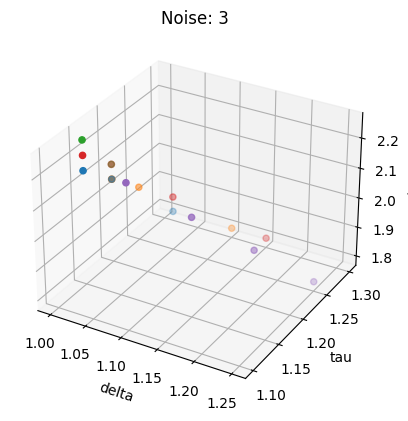

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

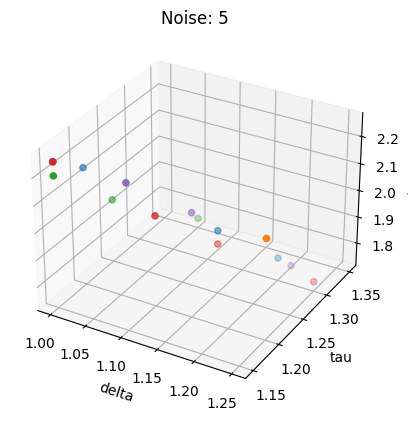

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

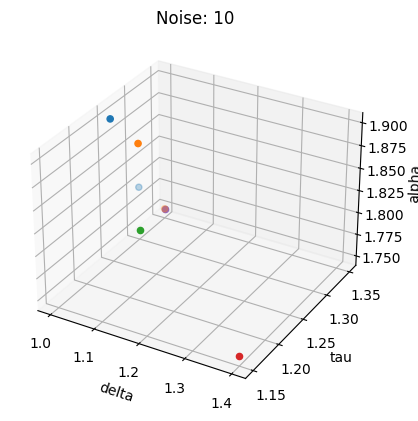

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         1    1.041188                 1.0  1.1500000000000004   
1         1         3    1.001472                 1.0  1.1500000000000004   
2         1         8    1.121243                 1.0  1.1500000000000004   
3         1        15    1.021578                 1.0  1.1500000000000004   
4         1        16    1.007413                 1.0  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2468     10        85  100.347113  1.6500000000000006  0.9500000000000002   
2469     10        82  102.300685  1.6500000000000006  1.1000000000000003   
2470     10        56  101.450214  1.6500000000000006  1.2000000000000004   
2471     10        85  100.355370  1.7000000000000006  1.0000000000000002   
2472     10        82  102.293028  1.7000000000000006  1.1500000000000004   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2468  2.0500000000000003  
2469                 2.0  
2470                1.75  
2471                1.85  
2472                1.85  

[2473 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.55  0.557320  2.0  3.0  4.0  4.00  5.0
2                      100.0  3.12  0.844232  1.0  3.0  3.0  4.00  4.0
3                      100.0  2.93  0.977060  1.0  2.0  3.0  4.00  5.0
4                      100.0  2.69  1.051166  1.0  2.0  3.0  3.25  4.0
5                      100.0  2.39  1.188285  1.0  1.0  2.0  4.00  4.0
6                      100.0  2.25  1.157976  1.0  1.0  2.0  3.00  4.0
7                      100.0  2.15  1.067187  1.0  1.0  2.0  3.00  4.0
8                      100.0  1.97  1.141105  1.0  1.0  2.0  3.00  5.0
9                      100.0  1.92  1.031621  1.0  1.0  2.0  3.00  4.0
10                     100.0  1.76  1.045626  1.0  1.0  1.0  3.00  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
0         1         1    1.041188   1.0  1.1500000000000004   
1         1         3    1.001472   1.0  1.1500000000000004   
2         1         8    1.121243   1.0  1.1500000000000004   
3         1        15    1.021578   1.0  1.1500000000000004   
4         1        16    1.007413   1.0  1.1500000000000004   
...     ...       ...         ...   ...                 ...   
2396     10        29  105.033733   1.0  1.5000000000000007   
2397     10        42   92.094766   1.0  1.5000000000000007   
2398     10        72   98.990951   1.0  1.5500000000000007   
2399     10        83  104.053529   1.0  1.5500000000000007   
2400     10        66   94.306761   1.0  1.6000000000000008   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2396                1.85  
2397  1.9500000000000002  
2398                1.75  
2399                1.75  
2400                1.75  

[1308 rows x 6 columns]

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
273       1        41    0.970975                1.05  1.3500000000000005   
274       1        67    1.099837                1.05  1.3500000000000005   
275       1        75    1.159096                1.05  1.3500000000000005   
317       1         2    1.061953                 1.1  1.3500000000000005   
318       1         4    1.018570                 1.1  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2462     10        26  109.601300  1.4500000000000004  1.2500000000000004   
2463     10        47   94.818106  1.5000000000000004  1.0000000000000002   
2464     10         3  104.009630  1.5500000000000005  1.0500000000000003   
2465     10         8   99.902445  1.5500000000000005  1.0500000000000003   
2470     10        56  101.450214  1.6500000000000006  1.2000000000000004   

     alpha  
273   1.75  
274   1.75  
275   1.75  
317   1.75  
318   1.75  
...    ...  
2462  1.75  
2463  1.75  
2464  1.75  
2465  1.75  
2470  1.75  

[453 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        38      3                 1.1   34    38      1  1.3500000000000005   
10       56     11                 1.0   33    56     13  1.3500000000000005   
2        27      5                 1.1   16    27      3  1.3500000000000005   
3        34      7  1.2000000000000002    9    34      5  1.3500000000000005   
4        38      8  1.2000000000000002    9    38      5  1.3000000000000005   
5        49      8                 1.0   18    49      5  1.3500000000000005   
6        56     10                 1.0   14    56      7  1.3500000000000005   
7        58     11                 1.0   15    58      9  1.3000000000000005   
8        51     13                 1.0   19    51     10  1.3500000000000005   
9        46     10                 1.0   24    46      8  1.3500000000000005   

            
      freq  
noise       
1       38  
10      12  
2       17  
3       13  
4       15  
5       17  
6       18  
7       14  
8       14  
9       11

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
29        1         0    1.019721                 1.0  1.1500000000000004   
30        1        11    0.953530                 1.0  1.1500000000000004   
31        1        18    1.241530                 1.0  1.1500000000000004   
32        1        20    0.987994                 1.0  1.1500000000000004   
33        1        27    1.023889                 1.0  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2423     10        89  104.523725  1.1500000000000001  1.1000000000000003   
2430     10        35  108.880762  1.2000000000000002  1.1500000000000004   
2454     10        53   93.720383  1.4000000000000004  0.9000000000000001   
2455     10        95  101.322321  1.4000000000000004  1.1500000000000004   
2466     10        85  100.355947  1.6000000000000005  0.9000000000000001   

                   alpha  
29    2.2500000000000004  
30    2.2500000000000004  
31    2.2500000000000004  
32    2.2500000000000004  
33    2.2500000000000004  
...                  ...  
2423  2.2500000000000004  
2430  2.2500000000000004  
2454  2.2500000000000004  
2455  2.2500000000000004  
2466  2.2500000000000004  

[196 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
1         9      1  1.0    9     9      1  1.1500000000000004    9
10       24      6  1.0   15    24      7  1.1000000000000003    7
2        14      1  1.0   14    14      1  1.1500000000000004   14
3        15      3  1.0   13    15      2  1.1500000000000004   11
4        23      3  1.0   18    23      3  1.1000000000000003   11
5        17      5  1.0    7    17      3  1.1000000000000003   11
6        23      6  1.0   13    23      4  1.1500000000000004   13
7        20      5  1.0   11    20      5  1.1000000000000003    8
8        29      9  1.0    9    29      8  1.0500000000000003    7
9        22      6  1.0    8    22      6  1.1000000000000003   10

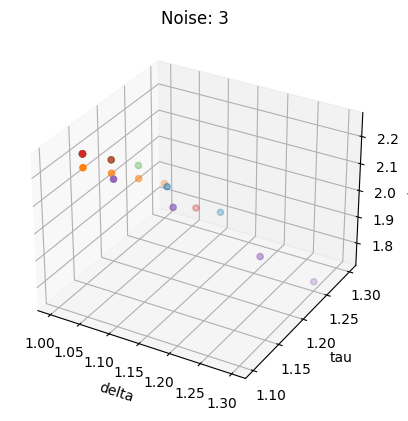

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

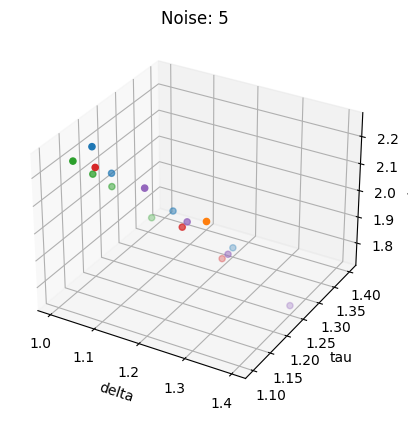

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

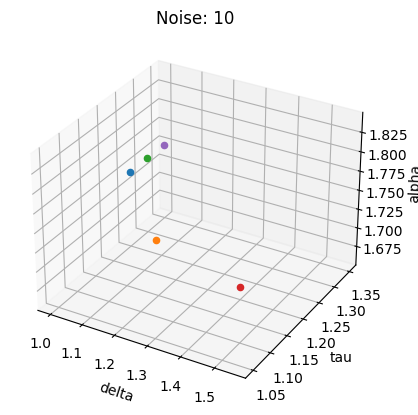

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()